In [1]:
from utils import *
from Model_gpu import ProtoRNN
from itertools import combinations
from itertools import chain as ch
from tqdm import tqdm, trange
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import numpy as np
import torch
import joblib

e:\Anaconda\envs\fam\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Build model

In [33]:
# image param
num_kernel = 64
num_row = 8
num_col = 8

# simulation param
tau_stim = 100
delta_t = 1 
save_every_stim = 1

# init model
f = ProtoRNN(num_kernel, num_row, num_col, tau_stim, delta_t, save_every_stim)

# set wrp [Optional]
# wrp = np.load('Circuits_scale_v3/weight_epoch4_tx25_100ms_500_64_5_5_v3.npy')
# f.wrp = wrp

# move to deivice
f.to(device)

ProtoRNN()

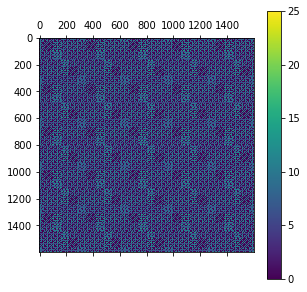

In [4]:
wrp = f.wrp.cpu().numpy()
plt.matshow(wrp * f.N_neighbors, vmax=f.wrp_max * f.N_neighbors)
plt.colorbar()

In [ ]:
wrp_o = np.load('Circuits_scale/weight_epoch1_multi40_200ms_500_64_5_5_v2.npy')
plt.matshow(wrp_o * f.N_neighbors, vmax=f.wrp_max * f.N_neighbors)
plt.colorbar()

### Simulation

In [34]:
# get stimuli for running
# r_in = np.load('tr_berkeley/r_in_abs_500_64_5_5.npy')
# r_in = torch.tensor(r_in).float().to(device)
# # sns.distplot(r_in)

mix_coef = 2
r_in = np.load('E:/Dataset/Lee/SMT-BCM_input_correct/r_in_cifar_all_noise_abs_5_4_10_64_8_8.npy')
r_in, t_ind, n_ind = insertTeachingSig(r_in, p=mix_coef)
r_in = torch.tensor(r_in).reshape(-1, 1, f.num_kernel, f.num_row, f.num_col).float().to(device)
r_in.shape

torch.Size([300, 1, 64, 8, 8])

In [6]:
# set simulation param
n_trials = 1
f.noise_test = 0

In [36]:
ys_test_all = []
# for i in trange(n_trials, desc='trials...', position=0):
for i in range(n_trials):
    # print(f'start trial{i} ...')
    # train_list = np.random.choice(10000, 600, replace=False)
    # num_stimuli = len(train_list)
    # r_in_new = r_in[train_list]

    ys_test = f.test(r_in, 0)
    # t, ys_test, count_test, count_img, circ, circ_per_neuron = f.test(y0, r_in_new, stim, inspecting=True)

    ys_test_all.append(ys_test.cpu().numpy())

ys_test_all = np.stack(ys_test_all).squeeze()
print(ys_test_all.shape)

testing...: 100%|██████████| 50000/50000 [00:27<00:00, 1841.18it/s]


In [38]:
# save
np.save(r'E:\Dataset\Lee\Response_scale//r_epoch2_faster_multi1_100ms_mean_500_1_64_5_5_v2.npy', ys_test_all)

#### BCM threshold based on ys

In [10]:
ys_test_all = np.load(r'E:\Dataset\Lee\Response_scale//r_pre_norm_multi1_100ms_mean_500_1_64_5_5.npy')

/tmp/ipykernel_20091/3979329063.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_r)


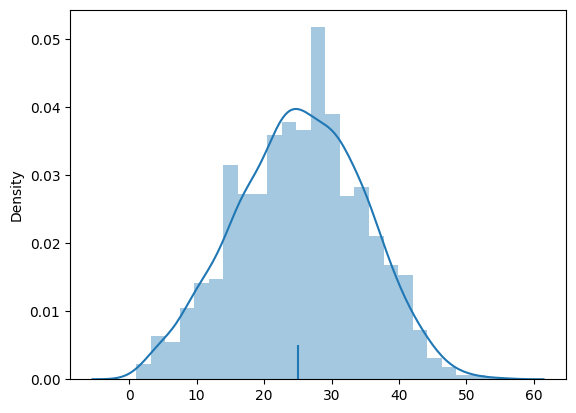

In [13]:
# obtaining BCM threshold based on mean (eliminate noise and trial=1)
ys_exc = f.r_numpy(ys_test_all[:, :f.N_e])
theta_BCM = (ys_exc ** 3).mean(0) * 7
# check BCM threshold (for each neuron only 5% of stimuli will be above the threshold)
r_in_sorted = np.sort(ys_exc, 0)[::-1]
high_r = np.sum(r_in_sorted > theta_BCM, axis=0)
sns.distplot(high_r)
plt.vlines(np.median(high_r),0, 0.005)

In [14]:
np.save('tr_berkeley/bcm_theta_abs_500_64_5_5.npy', theta_BCM)

#### PSTH and Tuning curve (figure1)

In [4]:
tm_ff = np.load('tr_berkeley/r_in_abs_500_64_5_5.npy')  # Img, Ne
tm_eq = np.load('Response_scale_v3/r_pre_rx1_100ms_mean_500_100_64_5_5_v3.npy')[:, :, :f.N_e]  # Img, T, Ne
# tm_eq_f = np.load('Response_scale_v3/r_epoch4_tx25_rx1_100ms_mean_500_100_64_5_5_v3.npy')[:, :, :f.N_e]

([<matplotlib.axis.YTick at 0x7f808a77ab60>,
 [Text(0, 0.0, '0.0'), Text(0, 1.0, '1.0'), Text(0, 2.0, '2.0')])

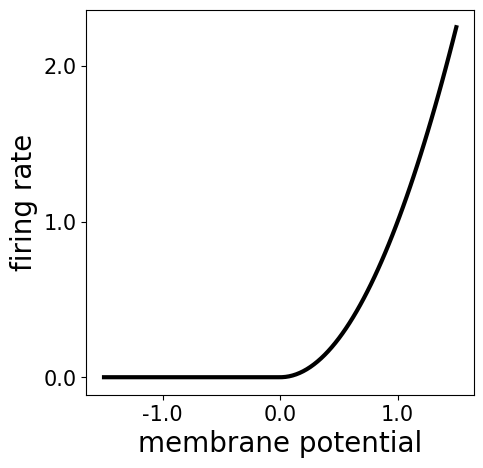

In [31]:
# activation function
fig = plt.figure(figsize=(5, 5))
xx = np.linspace(-1.5, 1.5, 100)
yy = f.r_numpy(xx)
plt.plot(xx, yy, color='black', linewidth=3)
plt.xlabel('membrane potential', fontsize=20)
plt.ylabel('firing rate', fontsize=20)
plt.xticks([-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0], fontsize=15)
plt.yticks([0.0, 1.0, 2.0], [0.0, 1.0, 2.0], fontsize=15)

(0.0, 0.8)

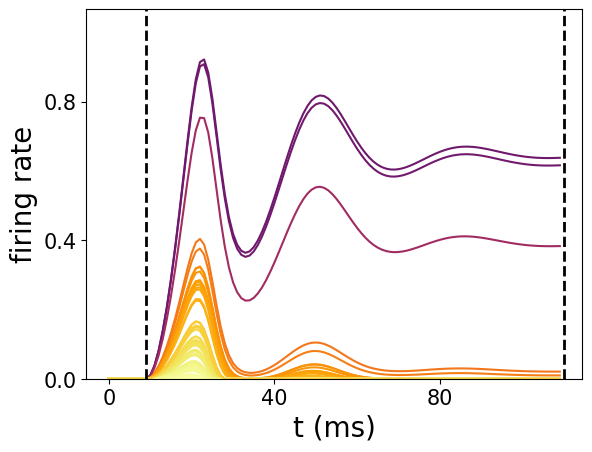

In [26]:
# before-after training
center_idx = take_center(np.arange(f.N_e), num_kernel, num_row, num_col, 1)
tm_eq_c = tm_eq[17, :, center_idx].T  # T, N_center
for i in range(tm_eq_c.shape[-1]):
    fr = np.concatenate([np.zeros(10), f.r_numpy(tm_eq_c[:, i])])
    colors = plt.cm.inferno_r(np.max(fr))
    plt.plot(fr, color=colors)
plt.xlabel('t (ms)', fontsize=20)
plt.ylabel('firing rate', fontsize=20)
plt.xticks([0, 40, 80], [0, 40, 80], fontsize=15)
plt.yticks([0.0, 0.3, 0.6], [0.0, 0.4, 0.8], fontsize=15)
plt.axvline(x=9, linestyle='--', linewidth=2, color='black')
plt.axvline(x=110, linestyle='--', linewidth=2, color='black')
plt.ylim(0, 0.8)

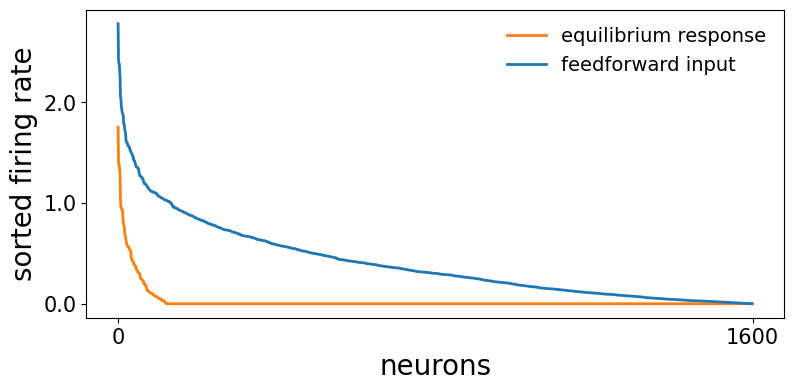

In [36]:
tm_ff_m = tm_ff[17].flatten()  # Ne
tm_eq_m = tm_eq[17, -5:].mean(0)  # Ne

# sorting
sort_ind = np.argsort(tm_ff_m)[::-1]
sort_ind2 = np.argsort(tm_eq_m)[::-1]
tm_ff_m = tm_ff_m[sort_ind]
tm_eq_m = tm_eq_m[sort_ind2]

fig = plt.figure(figsize=(9, 4))
plt.plot(tm_eq_m, color='tab:orange', label='equilibrium response', linewidth=2)
plt.plot(tm_ff_m, color='tab:blue', label='feedforward input', linewidth=2)
plt.xlabel('neurons', fontsize=20)
plt.ylabel('sorted firing rate', fontsize=20)
plt.xticks([0, 1600], [0, 1600], fontsize=15)
plt.yticks([0.0, 1.0, 2.0], [0.0, 1.0, 2.0], fontsize=15)
plt.legend(frameon=False, prop={'size': 14})

#### PSTH

In [37]:
ys_before = np.load('E:/Dataset/Lee/SMT-BCM_response_correct/r_pre_rx1_500ms_mean_5_4x10_250_64_8_8_mix50%_all.npy')
# ys_after1 = np.load('Response_scale_v3/r_epoch0_tx25_rx1_500ms_mean_500_250_64_5_5_v3.npy')
# ys_after3 = np.load('Response_scale_v3/r_epoch2_tx25_rx1_500ms_mean_500_250_64_5_5_v3.npy')
ys_after = np.load('E:/Dataset/Lee/SMT-BCM_response_correct/r_epoch4_tx30_rx1_500ms_mean_5_4x10_250_64_8_8_mix50%_2e9pos1e7_all.npy')
ys_before_exc = f.r_numpy(ys_before[:, :, :f.N_e])
# ys_after1_exc = f.r_numpy(ys_after1[:, :, :f.N_e])
# ys_after3_exc = f.r_numpy(ys_after3[:, :, :f.N_e])
ys_after_exc = f.r_numpy(ys_after[:, :, :f.N_e])
ys_after_exc.shape

(300, 251, 4096)

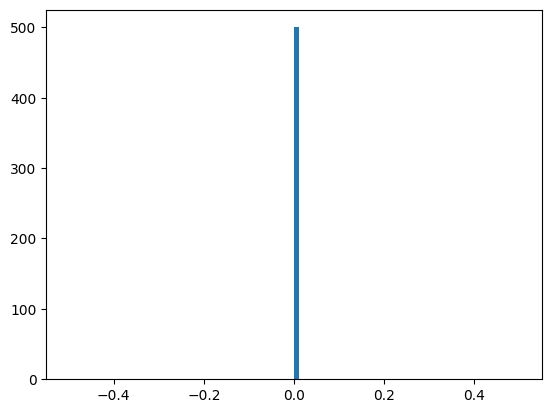

In [7]:
noys = []
for i in range(500):
    noy = np.linalg.norm(ys_after_exc[i, -1] - ys_after_exc[i, -2])
    noys.append(noy)
g = plt.hist(noys, bins=100)

Text(0, 0.5, 'average normalized firing rate')

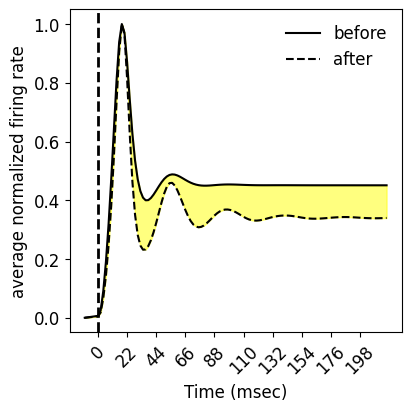

In [40]:
ys_mean_before = ys_before_exc.mean((0, 2))
# ys_mean_after1 = ys_after1_exc.mean((0, 2))
# ys_mean_after3 = ys_after3_exc.mean((0, 2))
ys_mean_after = ys_after_exc.mean((0, 2))
# dg = [ys_mean_after1, ys_mean_after3, ys_mean_after5]

psth_after = np.insert(ys_mean_after, 0, 0)
psth_after = psth_after / psth_after.max()
psth_before = np.insert(ys_mean_before, 0, 0)
psth_before = psth_before / psth_before.max()

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(4, 4))
x = np.insert(np.arange(0, 220, 2), 0, -10)
x_tick = np.arange(0, 220, 22)
axs.plot(x, psth_before[:111], '-', label='before', color='black')
axs.plot(x, psth_after[:111], "--", label='after', color='black')
axs.fill_between(x, psth_before[:111], psth_after[:111], color='yellow', alpha=.5)
axs.xaxis.set_ticks(x_tick, x_tick)
axs.tick_params(axis='x', rotation=45)
axs.axvline(x=0, linestyle='dashed', linewidth=2, color='black')
axs.legend(frameon=False)
axs.set_xlabel('Time (msec)')
axs.set_ylabel('average normalized firing rate')

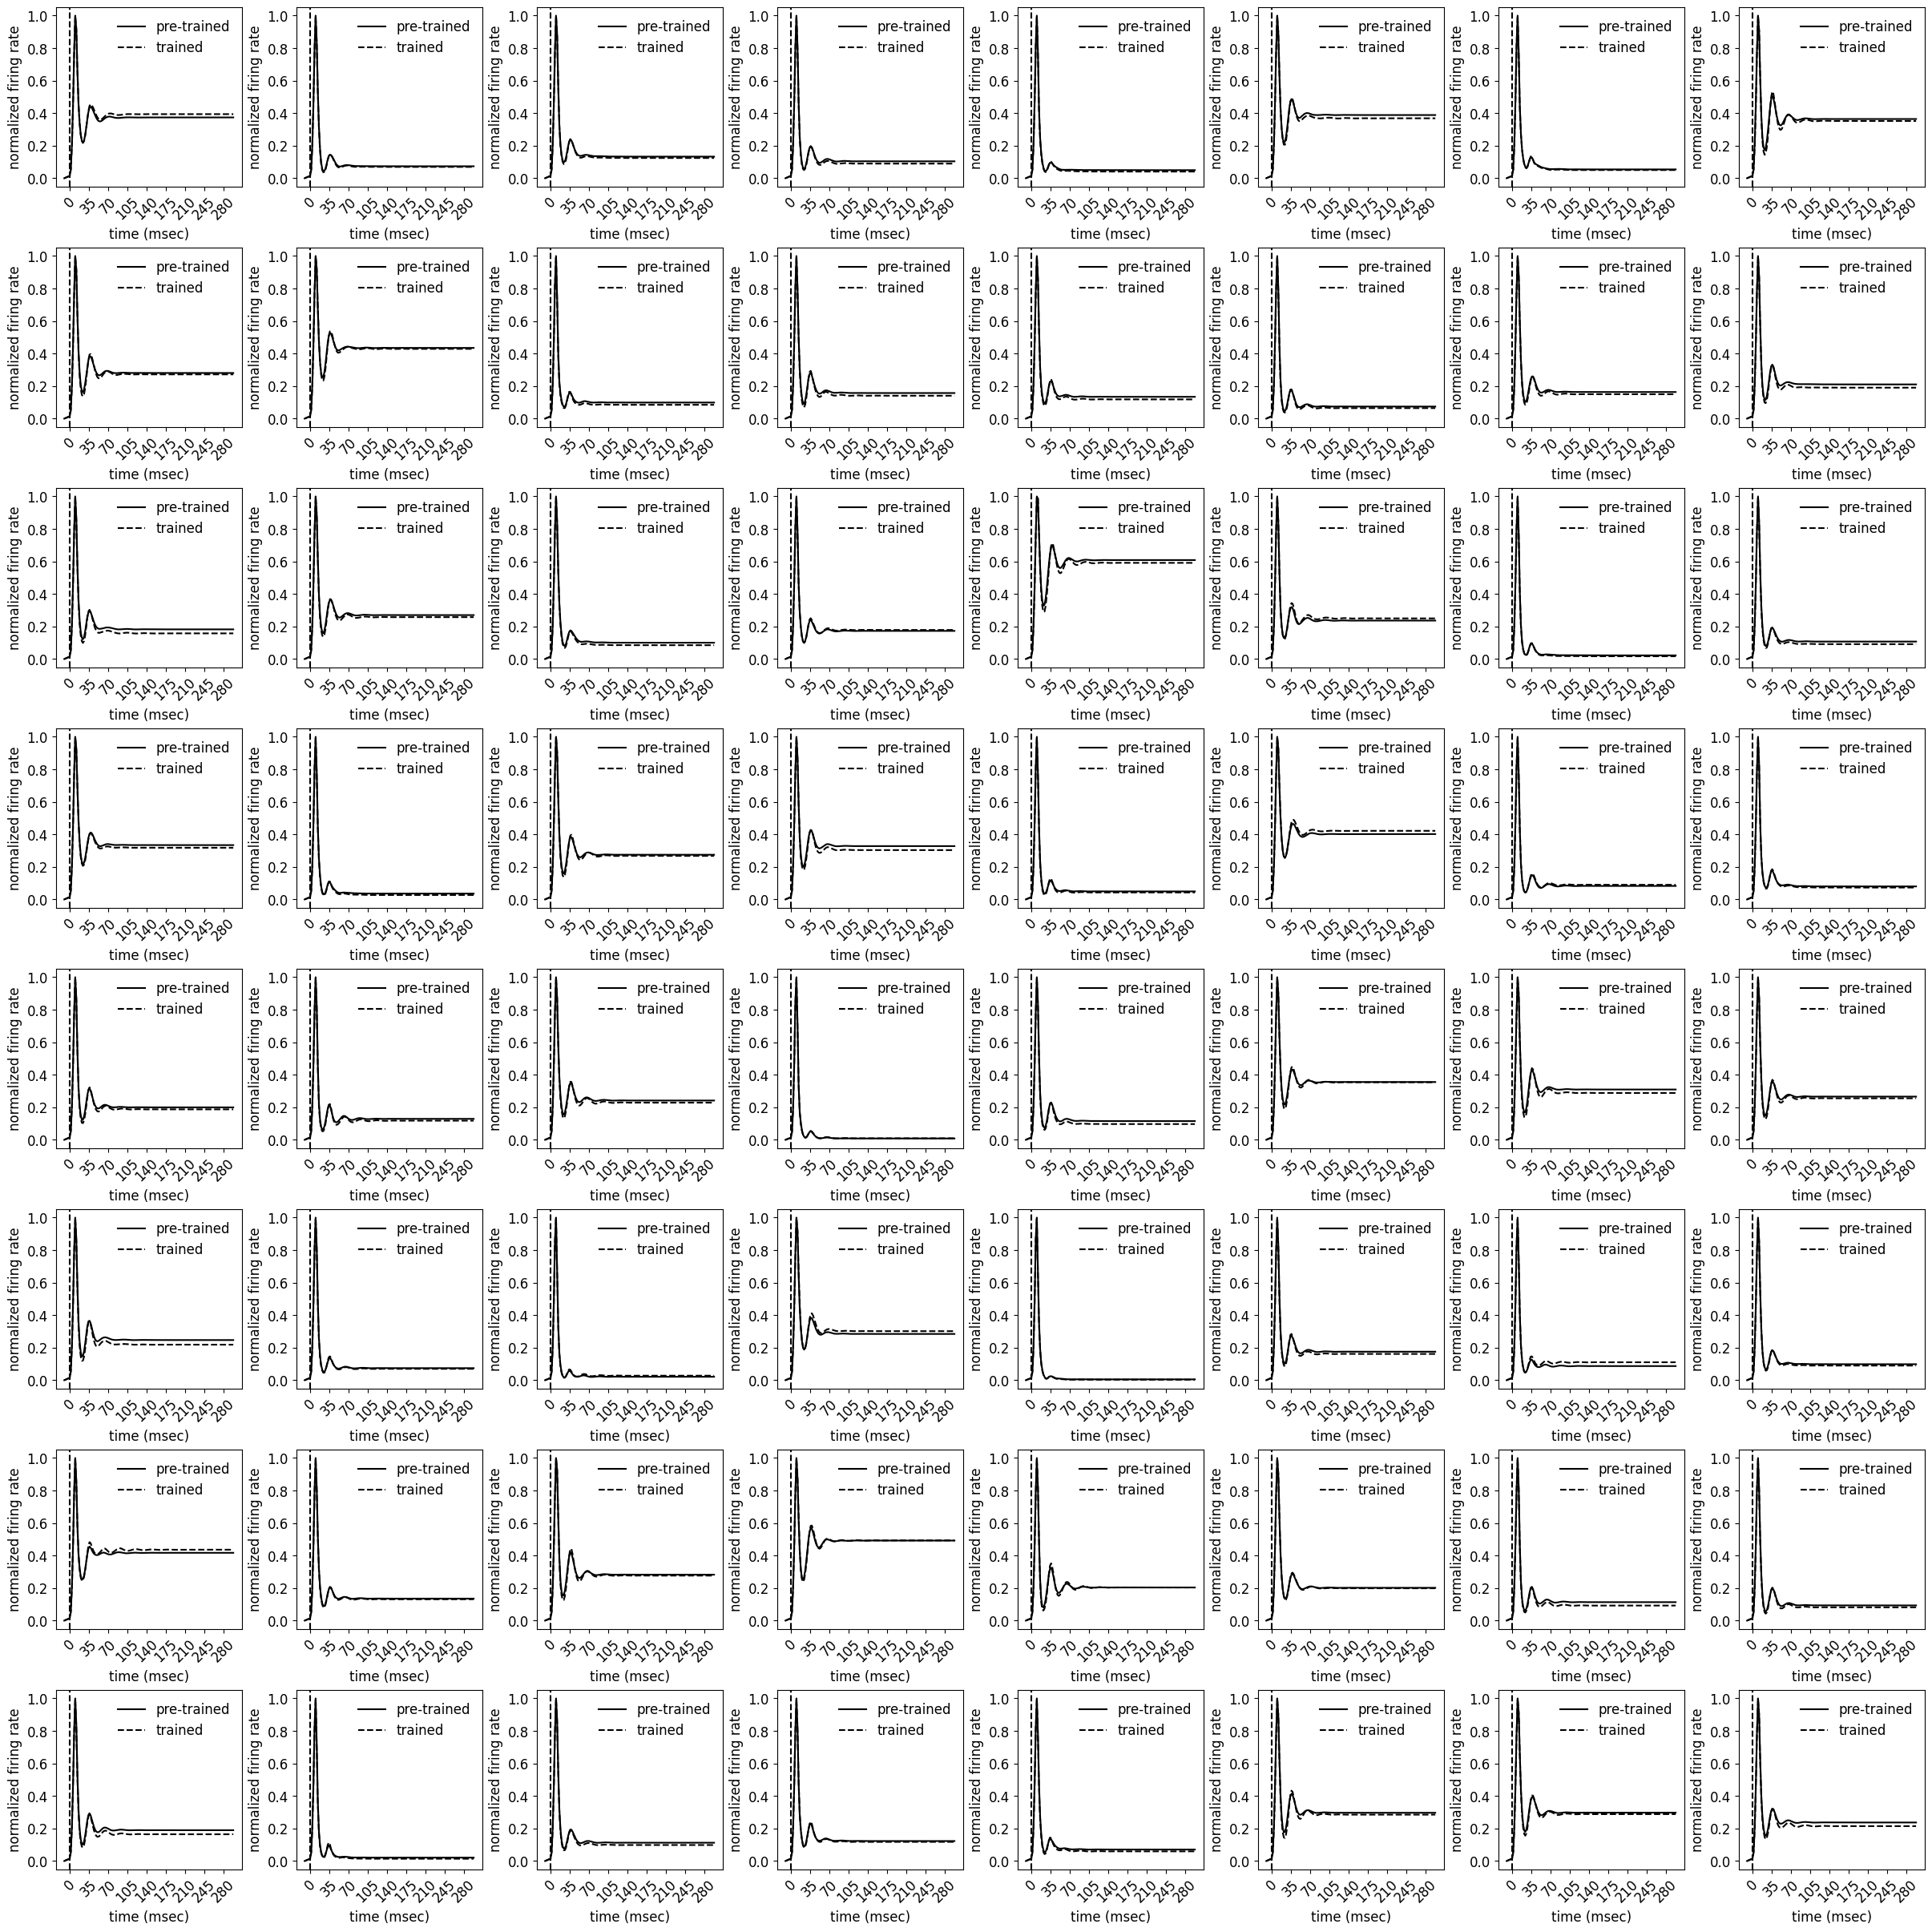

In [9]:
# PSTH avg over stim
center_idx = take_center(np.arange(f.N_e), num_kernel, num_row, num_col, 1)

ys_mean_before = ys_before_exc.mean(0)  # t, Ne
psth_before = np.insert(ys_mean_before[:, center_idx], 0, 0, axis=0)
psth_before = psth_before / psth_before.max(0, keepdims=True)

ys_mean_after = ys_after_exc.mean(0)
psth_after = np.insert(ys_mean_after[:, center_idx], 0, 0, axis=0)
psth_after = psth_after/ psth_after.max(0, keepdims=True)

fig, axs = plt.subplots(8, 8, constrained_layout=True, figsize=(24, 24))
axs = axs.flatten()
x = np.insert(np.arange(0, 300, 2), 0, -10)
x_tick = np.arange(0, 300, 35)
for i, ax in enumerate(axs):
    ax.plot(x, psth_before[:151, i], '-', label='pre-trained', color='black')
    ax.plot(x, psth_after[:151, i], '--', label='trained', color='black')
    ax.xaxis.set_ticks(x_tick, x_tick)
    ax.tick_params(axis='x', rotation=45)
    ax.axvline(x=0, linestyle='dashed', color='black')
    # ax.axvline(x=150, linestyle='dashed')
    ax.legend(frameon=False)
    ax.set_xlabel('time (msec)')
    ax.set_ylabel('normalized firing rate')
    # ax.set_title(f'center neuron {i + 1}')

#### Tuning

In [41]:
tm_before = np.load('E:/Dataset/Lee/SMT-BCM_response_correct/r_pre_rx1_500ms_mean_5_4x10_250_64_8_8_mix50%_all.npy')
# tm_before = tm_before[:, -2:].mean(1)
tm_before = seqUnmix(tm_before, t_ind, n_ind, n_imgs=5, npa=10)[:, -2:].mean(1)
# ys_after_epoch1 = np.load('Response/r_epoch0_slow_multi1_100ms_30trial_500_1_72_5_5.npy')
# ys_after_epoch2 = np.load('Response/r_epoch1_slow_multi1_100ms_30trial_500_1_72_5_5.npy')
tm_after = np.load('E:/Dataset/Lee/SMT-BCM_response_correct/r_epoch4_tx30_rx1_500ms_mean_5_4x10_250_64_8_8_mix50%_2e9pos1e7_all.npy')
tm_after = seqUnmix(tm_after, t_ind, n_ind, n_imgs=5, npa=10)[:, -2:].mean(1)
# tm_after = tm_after[:, -2:].mean(1)

tm_before = f.r_numpy(tm_before[:, :f.N_e])
tm_after = f.r_numpy(tm_after[:, :f.N_e])

print(tm_before.shape, tm_after.shape)

(200, 4096) (200, 4096)


Text(0.02, 0.5, '(after-before) / (after+before)')

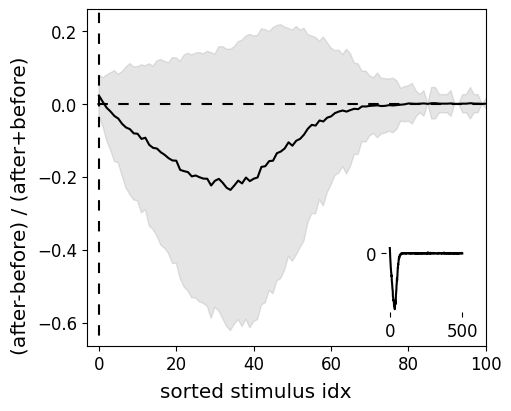

In [14]:
fig = plt.figure(layout="constrained", figsize=(5, 4))
# gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(gs[0, 1:])
axin1 = ax1.inset_axes([0.75, 0.1, 0.2, 0.2])
sortind1 = np.argsort(tm_before, axis=0)[::-1]
# sortind2 = np.argsort(tm_after, axis=0)[::-1]
# ax1.plot(np.take_along_axis(tm_before, sortind1, axis=0).mean(-1), label='novel', alpha=.5)
# ax1.plot(np.take_along_axis(tm_after, sortind2, axis=0).mean(-1), label='familier', alpha=.5)
# ax1.set_xlim((-3, 80))
# ax1.set_ylabel('averaged sorted response')
# ax1.legend(frameon=False)
tm_before_sorted = np.take_along_axis(tm_before, sortind1, axis=0)
tm_after_sorted = np.take_along_axis(tm_after, sortind1, axis=0)
diff_idx = (tm_after_sorted - tm_before_sorted) / (tm_after_sorted + tm_before_sorted + 1e-8)
diff_mean = diff_idx.mean(-1)
diff_std = diff_idx.std(-1)
ax1.plot(diff_mean, color='black')
ax1.fill_between(np.arange(0, 500), diff_mean - diff_std, diff_mean + diff_std, alpha=0.2, color='grey')
ax1.axhline(y=0.00, color='black', linestyle=(5, (5, 5)))
ax1.axvline(x=0.00, color='black', linestyle=(5, (5, 5)))
ax1.set_xlim((-3, 100))
axin1.plot(diff_mean, color='black')
axin1.spines.right.set_visible(False)
axin1.spines.top.set_visible(False)
axin1.spines.left.set_visible(False)
axin1.spines.bottom.set_visible(False)
axin1.yaxis.set_ticks([0], ['0'])
axin1.xaxis.set_ticks([0, 500], ['0', '500'])
fig.supxlabel('sorted stimulus idx')
fig.supylabel('(after-before) / (after+before)')

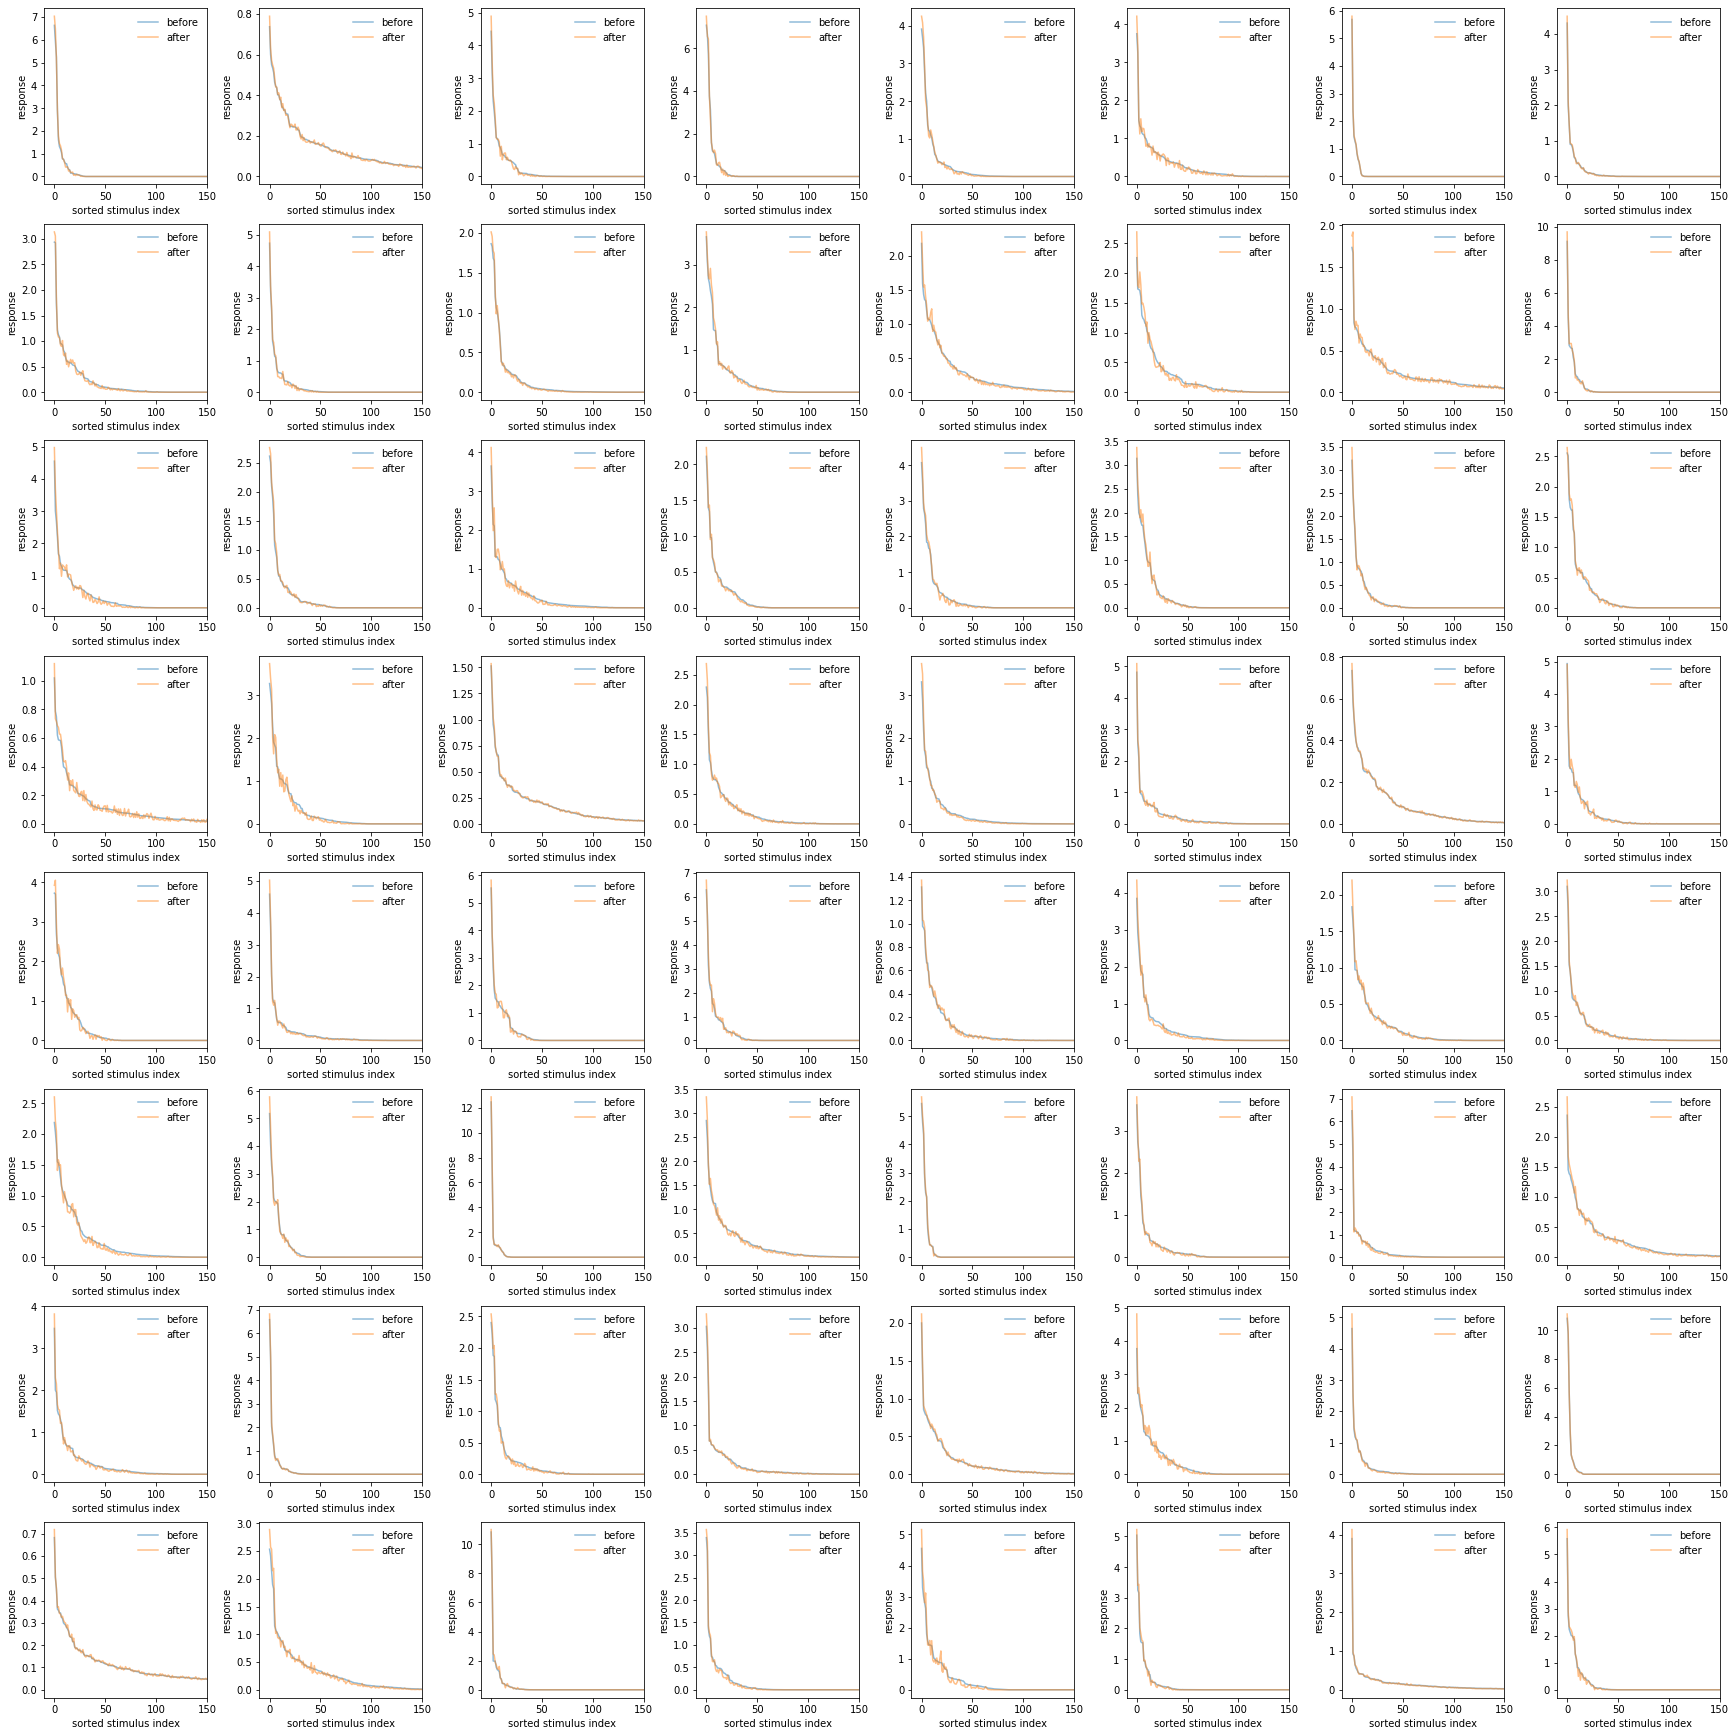

In [55]:
# single neuron tuning
# center_idx = take_center(np.arange(f.N_e), num_kernel, num_row, num_col, 1)
# tm_before_kernel = tm_before.reshape(tm_before.shape[0], num_kernel, -1)[:, :, 12]
# tm_after_kernel = tm_after.reshape(tm_after.shape[0], num_kernel, -1)[:, :, 12]
# tm_before_kernel_max = tm_before_kernel.max(0)
# tm_after_kernel_max = tm_after_kernel.max(0)
# tm_before_kernel_norm = (tm_before_kernel / tm_before_kernel_max).mean(-1)
# tm_after_kernel_norm = (tm_after_kernel / tm_after_kernel_max).mean(-1)

fig, axs = plt.subplots(8, 8, constrained_layout=True, figsize=(24, 24))
axs = axs.flatten()

for i in range(64):
    ax = axs[i]
    sortind = np.argsort(tm_before[i+64])[::-1]
    tm_before_ = tm_before[i+64][sortind]
    tm_after_ = tm_after[i+64][sortind]
    ax.plot(tm_before_, alpha=.5, label='before')
    ax.plot(tm_after_, alpha=.5, label='after')
    ax.set_xlim(-10, 150)
    ax.legend(frameon=False)
    # ax.set_title(f'neuron{i}')
    ax.set_xlabel('sorted stimulus index')
    ax.set_ylabel('response')
# fig.supxlabel('sorted stimulus index')
# fig.supylabel('response')

Text(0, 0.5, 'response')

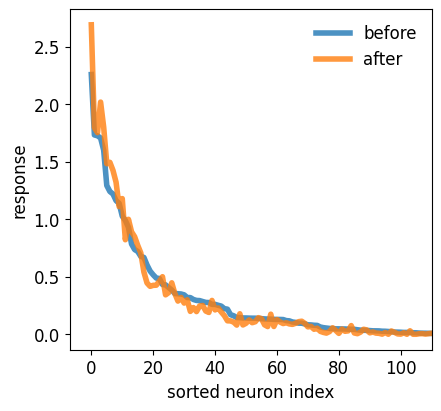

In [27]:
# single neuron tuning
# tm_before_kernel = tm_before.reshape(tm_before.shape[0], num_kernel, -1)[:, :, 12]
# tm_after_kernel = tm_after.reshape(tm_after.shape[0], num_kernel, -1)[:, :, 12]

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(4.3, 4))

i = 77
sortind = np.argsort(tm_before[i])[::-1]
tm_before_ = tm_before[i][sortind]
tm_after_ = tm_after[i][sortind]
ax.plot(tm_before_, alpha=.8, label='before', linewidth=4)
ax.plot(tm_after_, alpha=.8, label='after', linewidth=4)
ax.set_xlim(-7, 110)
ax.legend(frameon=False)
# ax.set_title(f'neuron{i}')
ax.set_xlabel('sorted neuron index')
ax.set_ylabel('response')

Text(0, 0.5, 'Probability density (stimulus)')

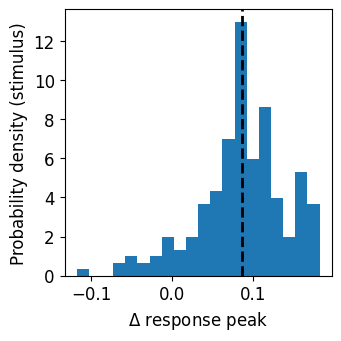

In [44]:
# sparsity vs max tuning
max_before = tm_before.max(1)
max_after = tm_after.max(1)
max_diff = (max_after - max_before) / (max_after + max_before)

# half height counting
# hh_before = max_before / 2
# hh_after = max_after / 2
# counts_above_hh_before = np.sum(tm_before > hh_before, 0)
# counts_above_hh_after = np.sum(tm_after > hh_after, 0)
# counts_diff = counts_above_hh_after - counts_above_hh_before

x = np.repeat(np.array(['before', 'after']), f.N_e)

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3.3, 3.3))

# axs[0].scatter(counts_above_hh_before, counts_above_hh_after, s=.3)
# axs[0].set_xlim(0, 10)
# axs[0].set_ylim(0, 10)
# axs[0].axline((0, 0), slope=1.0, color="tab:red")
# axs[0].hist(counts_diff, bins=20, fill='black', density=True)
# axs[0].set_xlabel(r'$\Delta$ counts')
# axs[0].axvline(x=counts_diff.mean(), linestyle='dashed', color='black', linewidth=2)
# axs[0].set_ylabel('Probability density')
# axs[0].set_yticks([50, 150, 250, 350, 450])
# axs[0].set_ylabel('above half count after')
# axs[0].legend(frameon=False)

# axs[1].scatter(max_before, max_after, s=.3)
# axs[1].set_xlim(0, 14)
# axs[1].set_ylim(0, 14)
# axs[1].axline((0, 0), slope=1.0, color="tab:red")
axs.hist(max_diff, bins=20, fill='black', density=True)
axs.set_xlabel(r'$\Delta$ response peak')
axs.axvline(x=max_diff.mean(), linestyle='dashed', color='black', linewidth=2)
axs.set_ylabel('Probability density (stimulus)')
# axs.set_yticks([0, 3, 6, 9, 12])
# axs[1].set_ylabel('max response after')
# axs[1].legend(frameon=False)

In [45]:
def sparseness(tuning):
    """
    Calculate the tuning sparsity according to 

    :param tuning: neural tuning of shape (n_stimulus, n_neuron)
    :return: sparsity of tuning for each neuron
    """
    n = tuning.shape[0]
    return (1 - ((tuning.sum(0)/n)**2/((tuning**2/n).sum(0) + 1e-8)))/(1 - (1/n))

Text(0, 0.5, 'Probability density (neuron)')

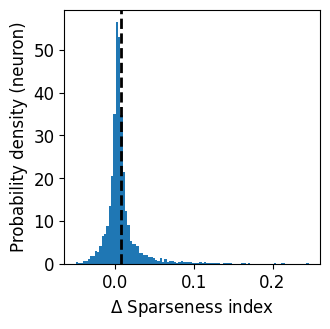

In [49]:
# Zenith-Yetcker sparseness
sp_before = sparseness(tm_before)
sp_after = sparseness(tm_after)
sp_diff = (sp_after - sp_before) / (sp_after + sp_before)

fig = plt.figure(figsize=(3.3, 3.3))
# plt.scatter(sp_before, sp_after, s=.3)
# plt.axline((0.9, 0.9), slope=1.0, color="tab:red")
# plt.xlabel('Vinji-Gallant sparseness index novel')
# plt.ylabel('Vinji-Gallant sparseness index familiar')
plt.hist(sp_diff, bins=100, density=True)
plt.axvline(x=sp_diff.mean(), linestyle='dashed', color='black', linewidth=2)
plt.xlabel(r'$\Delta$ Sparseness index')
plt.ylabel('Probability density (neuron)')

Text(0.02, 0.5, '(after-before) / (after+before)')

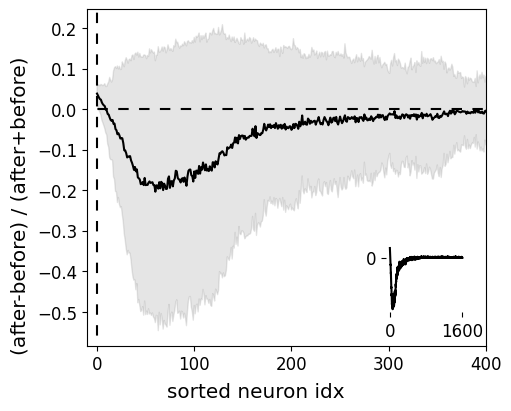

In [32]:
# populational response for novel and familiar input
# idx = 288
# sortind = np.argsort(tm_before[idx])[::-1]
# pr_before = tm_before[idx, sortind]
# pr_after = tm_after[idx, sortind]
# pr_before = tm_before.mean(0)
# pr_after = tm_after.mean(0)
sortind1 = np.argsort(tm_before, axis=1)[:, ::-1]
# sortind2 = np.argsort(tm_after, axis=1)[::-1]
pr_before = np.take_along_axis(tm_before, sortind1, axis=1)
pr_after = np.take_along_axis(tm_after, sortind1, axis=1)
diff_idx = (pr_after - pr_before) / (pr_after + pr_before + 1e-8)
diff_mean = diff_idx.mean(0)
diff_std = diff_idx.std(0)

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 4))
# ax1.plot(pr_before, label='novel')
# ax1.plot(pr_after, label='familiar')
# ax1.legend(frameon=False)
# ax1.set_xlim((-10, 100))
# ax1.set_ylabel('neuron response')

ax1.plot(diff_mean, color='black')
ax1.fill_between(np.arange(0, 1600), diff_mean - diff_std, diff_mean + diff_std, alpha=0.2, color='grey')
ax1.set_xlim((-10, 400))
ax1.axhline(y=0.00, color='black', linestyle=(5, (5, 5)))
ax1.axvline(x=0.00, color='black', linestyle=(5, (5, 5)))
axin1 = ax1.inset_axes([0.75, 0.1, 0.2, 0.2])
axin1.plot(diff_mean, color='black')
axin1.spines.right.set_visible(False)
axin1.spines.top.set_visible(False)
axin1.spines.left.set_visible(False)
axin1.spines.bottom.set_visible(False)
axin1.yaxis.set_ticks([0], ['0'])
axin1.xaxis.set_ticks([0, 1600], ['0', '1600'])
fig.supxlabel('sorted neuron idx')
fig.supylabel('(after-before) / (after+before)')